# Building a model function

DLTK's current examples build on Tensorflow's high-level API with [tf.Estimator](https://www.tensorflow.org/api_docs/python/tf/estimator). For that you need to define a model function that specifies the computational graph, training function and so on. Good resources are [here](https://www.tensorflow.org/extend/estimators) and [here](https://www.tensorflow.org/get_started/estimator).

To start we are building a read function that we can use for training our model on. Here we rely on a simpe toy example with overlapping circles in a noisy image. Also, the read_fn does not rely on the `file_references` this time and just ignores it.

In [1]:
import SimpleITK as sitk
import tensorflow as tf
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from dltk.io.augmentation import *
from dltk.io.preprocessing import *

tf.logging.set_verbosity(tf.logging.ERROR)

# generate simple toy dataset
imwidth=256
imheight=256
numImgs = 200

def createTestImage(width,height,numObjs=12,radMax=30):
    '''Return a noisy 2D image with `numObj' circles and a 2D mask image.'''
    image=np.zeros((width,height))

    for i in range(numObjs):
        x=np.random.randint(radMax,width-radMax)
        y=np.random.randint(radMax,height-radMax)
        rad=np.random.randint(10,radMax)
        spy,spx = np.ogrid[-x:width-x, -y:height-y]
        circle=(spx*spx+spy*spy)<=rad*rad
        image[circle]=np.random.random()*0.5+0.5

    norm=np.random.uniform(0,0.25,size=image.shape)

    return np.maximum(image,norm),(image>0).astype(np.int32)  

# similar read_fn as before
def read_fn(file_references, mode, params=None):
    im, mask = createTestImage(imwidth,imheight)
    yield {'features': {'x': im[np.newaxis, :, :, np.newaxis]}, 'labels': {'y': mask[np.newaxis]}}

## (OPTIONAL) How to put plots in Jupyter Notebooks
The next box might be a little confusing and is only important for logging here in notebooks. If you don't care about it - just skip it. Otherwise it might be an interesting exampel for custom SessionRunHooks. We simply define a hook for Tensorflow that is run with every session run. Here we tell the session to also fetch us certain tensors that we can then extract from `run_values` in the `after_run` function. We then use that together with the IPython display bits to plot the progress of this training.

In [2]:
from matplotlib import pyplot as plt
from IPython import display

%matplotlib inline

class NotebookLoggingHook(tf.train.SessionRunHook):
    def __init__(self, fetches):
        self.fetches = fetches
        self.loss = []
        
    def before_run(self, run_context):
        # add the tensors to fetch to the session
        return tf.train.SessionRunArgs(self.fetches)
    
    def after_run(self, run_context, run_values):
        # extract the results of the fetched tensors
        fetch_dict = run_values.results
        
        # assume to have {'loss': scalar, 'input': img, 'output': img, 'truth': img}
        self.loss.append(fetch_dict['loss'])
        
        # plot stuff
        f, axarr = plt.subplots(2, 2, figsize=(16,8))
        axarr[0,0].imshow(np.squeeze(fetch_dict['x'][0,0,:,:,0]), cmap='gray')
        axarr[0,0].set_title('Input: x')
        axarr[0,0].axis('off')

        axarr[0,1].plot(self.loss)
        axarr[0,1].set_title('Crossentropy loss')
        axarr[0,1].set_yscale('log')
        axarr[0,1].axis('on')

        axarr[1,0].imshow(np.squeeze(fetch_dict['y_'][0,0,:,:]), cmap='gray', vmin=0, vmax=1)
        axarr[1,0].set_title('Prediction: y_')
        axarr[1,0].axis('off')

        axarr[1,1].imshow(np.squeeze(fetch_dict['y'][0,0,:,:]), cmap='gray', vmin=0, vmax=1)
        axarr[1,1].set_title('Truth: y')
        axarr[1,1].axis('off')

        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close(f)


Next we are defining the model function that always has to take the arguments `features`, `labels`, `mode`, and `params`. The function has to return a [`tf.estimator.EstimatorSpec`](https://www.tensorflow.org/api_docs/python/tf/estimator/EstimatorSpec) that is used by a [`tf.estimator.Estimator`](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator) to perform training etc. . The `EstimatorSpec` also holds the optimiser and information about evaluation metrics etc.

In [3]:
nl_hook = NotebookLoggingHook(None)
hooks = [nl_hook]

def model_fn(features, labels, mode, params):
    # 1. create a model and its outputs
    from dltk.models.segmentation.fcn import residual_fcn_3D
    net_output_ops = residual_fcn_3D(features['x'], 2, num_res_units=1, filters=(16, 32, 64),
                    strides=((1, 1, 1), (1, 2, 2), (1, 2, 2)), mode=mode)
    
    # 1.1 Generate predictions only (for `ModeKeys.PREDICT`)
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=net_output_ops,
                                          export_outputs={'out': tf.estimator.export.PredictOutput(net_output_ops)})
    
    # 2. set up a loss function
    loss = tf.losses.sparse_softmax_cross_entropy(labels['y'], net_output_ops['logits'])
    
    # 3. define a training op and ops for updating moving averages (i.e. for batch normalisation)  
    global_step = tf.train.get_global_step()
    optimiser = tf.train.AdamOptimizer(learning_rate=params["learning_rate"], epsilon=1e-5)
      
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimiser.minimize(loss, global_step=global_step)
    
    # 4.1 (optional) create custom summaries to be plotted with our custom hook
    my_notebook_fetches = {}
    my_notebook_fetches['loss'] = loss
    my_notebook_fetches['x'] = features['x']
    my_notebook_fetches['y'] = labels['y']
    my_notebook_fetches['y_'] = net_output_ops['y_']
    nl_hook.fetches = my_notebook_fetches
    
    # 5. Return EstimatorSpec object
    return tf.estimator.EstimatorSpec(mode=mode, predictions=net_output_ops, loss=loss, train_op=train_op, eval_metric_ops=None)

The next cell creates a reader object as shown before in the other tutorial notebook.

In [4]:
from dltk.io.abstract_reader import Reader
# Set up a data reader to handle the file i/o. 
reader_example_shapes = {'features': {'x': [1, imwidth, imheight, 1]},
                         'labels': {'y': [1, imwidth, imheight]}}
reader = Reader(read_fn, {'features': {'x': tf.float32}, 'labels': {'y': tf.int32}})

input_fn, qinit_hook = reader.get_inputs(None, tf.estimator.ModeKeys.TRAIN,
                                         example_shapes=reader_example_shapes)

We then use our model function to build a [`tf.estimator.Estimator`](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator). It does automatic checkpointing if you set a `model_dir`. The params are passed to the `model_fn`.

In [5]:
# get an estimator for training and everything
nn = tf.estimator.Estimator(model_fn=model_fn, model_dir=None, params={"learning_rate": 0.001})

We then finally train the estimator with the simple [`estimator.train`](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator#train) function using the input function created and the custom hooks for logging.

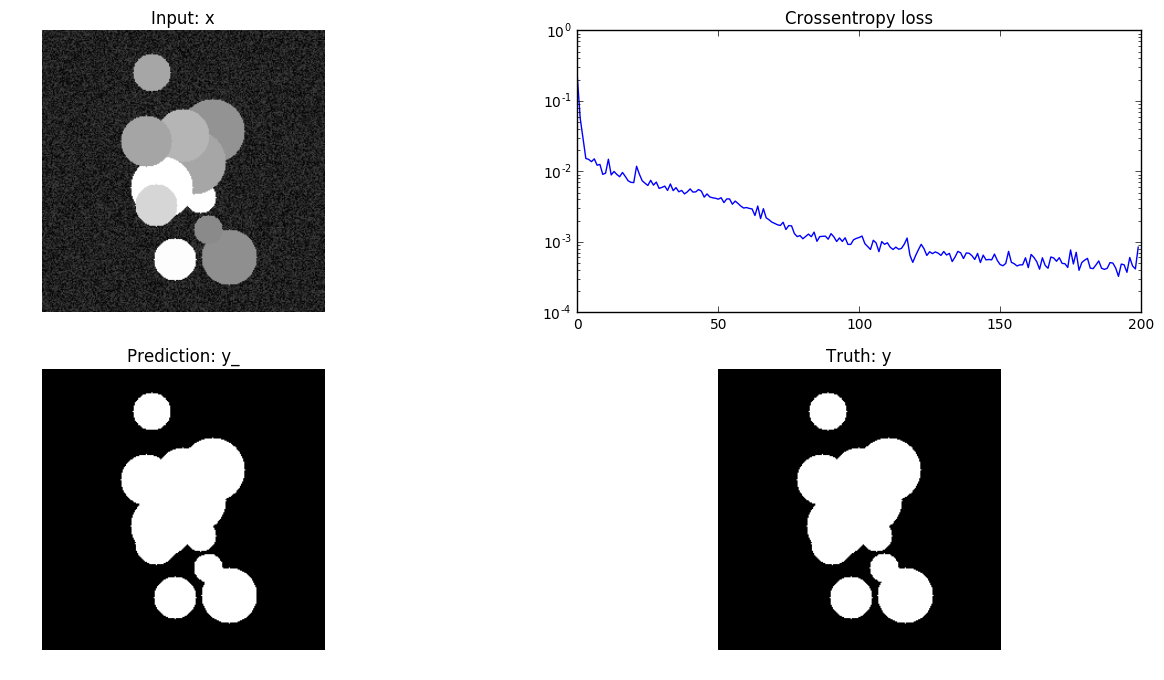

In [6]:
# train the estimator for 200 steps and have the custom hook do the plotting
_ = nn.train(input_fn=input_fn, hooks=hooks + [qinit_hook], steps=200)

Similarly to [`estimator.train`](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator#train) we can [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator#evaluate) the model:

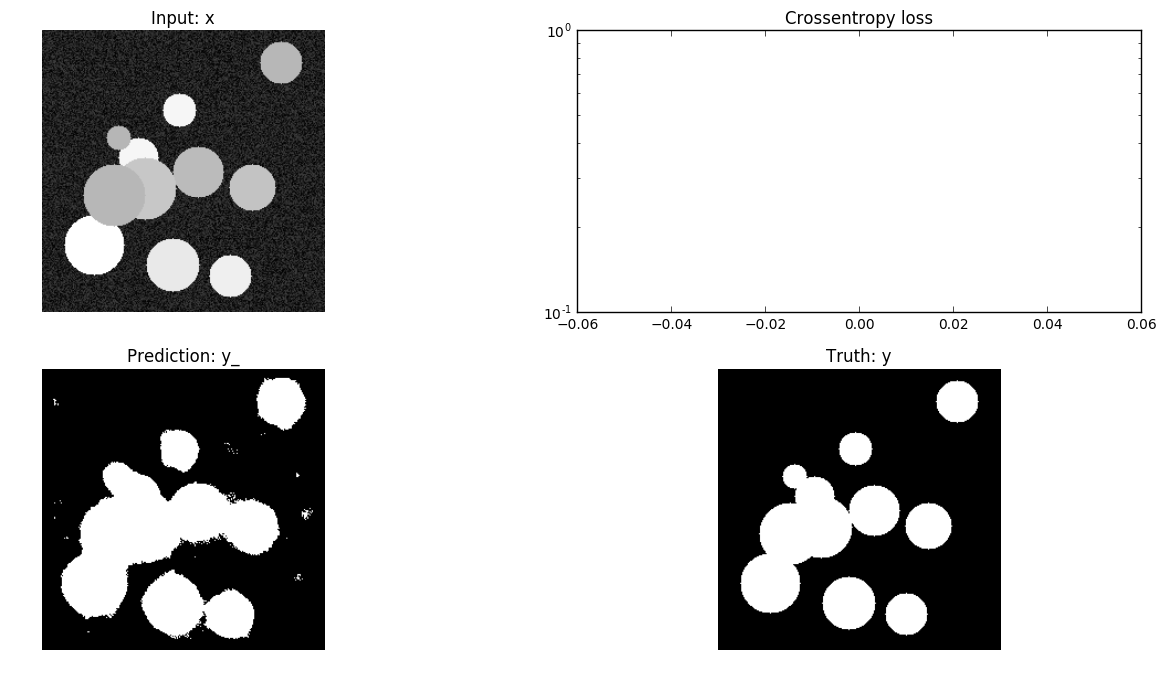

In [7]:
# do an evaluation of the estimator
nl_hook.loss = []
eval_input_fn, eval_qinit_hook = reader.get_inputs(None, tf.estimator.ModeKeys.EVAL,
                                         example_shapes=reader_example_shapes)

_ = nn.evaluate(input_fn=eval_input_fn, hooks=hooks + [eval_qinit_hook], steps=1)